In [9]:
# In a Jupyter notebook, you often have cell-by-cell code execution.
# We'll place all necessary imports here.

import os
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import numpy as np

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

# Initialize MediaPipe Pose and Drawing utils
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

In [10]:
def apply_projection_matrix(landmark_list, projection_matrix, image_shape):
    """
    Applies a custom projection to each landmark.
    This is a simplified example that treats each landmark as (x, y, z) in normalized space
    and transforms it into image-space coordinates using a 4x4 projection matrix.

    :param landmark_list: list of PoseLandmark objects (x, y, z) in [0..1] range.
    :param projection_matrix: 4x4 numpy array for homogeneous coordinates.
    :param image_shape: (height, width) of the image, used for final scaling.
    :return: list of 2D projected points (px, py) in image pixel coordinates.
    """
    h, w = image_shape
    projected_points = []

    for lm in landmark_list:
        # Extract normalized coordinates
        x_norm = lm.x
        y_norm = lm.y
        z_norm = lm.z

        # Convert to homogeneous coordinates: (x, y, z, 1)
        point_3d = np.array([x_norm, y_norm, z_norm, 1.0], dtype=np.float32)

        # Apply the projection
        transformed = projection_matrix @ point_3d

        # Avoid division by zero; if w-component is 0, we skip
        if not np.isclose(transformed[3], 0.0):
            # Normalize homogeneous coordinates
            x_proj = transformed[0] / transformed[3]
            y_proj = transformed[1] / transformed[3]
            # z_proj = transformed[2] / transformed[3]  # if you need Z, uncomment

            # Scale to actual image coordinates
            px = int(x_proj * w)
            py = int(y_proj * h)
        else:
            # Fallback: ignore or store invalid
            px, py = None, None

        projected_points.append((px, py))

    return projected_points

In [11]:
def check_landmarks_in_images_with_projection(image_dir, projection_matrix=None):
    """
    Loads images from the specified directory, applies MediaPipe Pose,
    manually applies a custom projection to the landmarks, and displays
    a quick visualization of the detected landmarks on the original image.

    :param image_dir: Path to the directory containing your raw images.
    :param projection_matrix: 4x4 numpy array for a custom projection.
                             If None, uses an identity matrix as a fallback.
    """
    if not os.path.exists(image_dir):
        print(f"[ERROR] Directory '{image_dir}' does not exist.")
        return

    # Valid image extensions
    valid_extensions = ('.jpg', '.jpeg', '.png')
    files = [f for f in os.listdir(image_dir) if f.lower().endswith(valid_extensions)]

    if not files:
        print(f"[INFO] No valid image files found in directory '{image_dir}'.")
        return

    # Use an identity matrix if no custom projection is provided
    if projection_matrix is None:
        projection_matrix = np.eye(4, dtype=np.float32)

    for img_file in files:
        img_path = os.path.join(image_dir, img_file)

        image_bgr = cv2.imread(img_path)
        if image_bgr is None:
            print(f"[WARNING] Could not read {img_file}, skipping.")
            continue

        # Convert to RGB for MediaPipe
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        h, w, _ = image_rgb.shape

        # Initialize Pose in static_image_mode
        with mp_pose.Pose(static_image_mode=True,
                          model_complexity=1,        # You can adjust the complexity level
                          enable_segmentation=False, # Turn off segmentation if not needed
                          min_detection_confidence=0.5,
                          min_tracking_confidence=0.5) as pose_detector:

            results = pose_detector.process(image_rgb)

            if results.pose_landmarks:
                # Convert landmarks to a list for easier manipulation
                landmarks = results.pose_landmarks.landmark

                # Apply the custom projection matrix
                projected_points = apply_projection_matrix(
                    landmarks,
                    projection_matrix,
                    (h, w)  # image shape
                )

                # Create a copy for annotation
                annotated_image = image_rgb.copy()

                # Optional: draw the original landmarks for debugging
                mp_drawing.draw_landmarks(
                    annotated_image,
                    results.pose_landmarks,
                    mp_pose.POSE_CONNECTIONS
                )

                # Draw projected points as small circles
                for (px, py) in projected_points:
                    if px is not None and py is not None:
                        cv2.circle(
                            annotated_image,
                            (px, py),
                            radius=5,
                            color=(0, 255, 0),
                            thickness=-1
                        )

                # Show result in the notebook
                plt.figure(figsize=(5, 4))
                plt.imshow(annotated_image)
                plt.title(f"Projection Matrix Check: {img_file}")
                plt.axis("off")
                plt.show()
            else:
                print(f"[INFO] No landmarks detected in {img_file}.")

I0000 00:00:1737406757.480815 2274473 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1737406757.530397 2298635 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737406757.538194 2298635 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


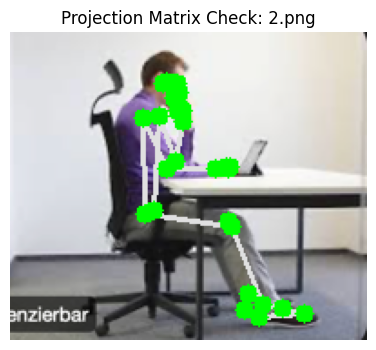

I0000 00:00:1737406757.584397 2274473 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1737406757.622340 2298650 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737406757.630017 2298650 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


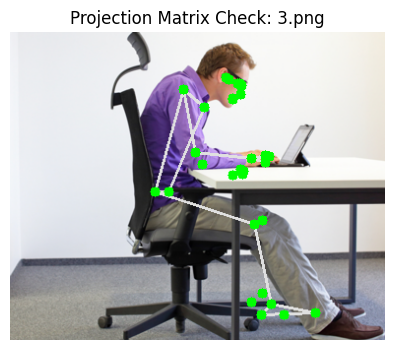

I0000 00:00:1737406757.675475 2274473 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1737406757.713504 2298660 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737406757.721032 2298662 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


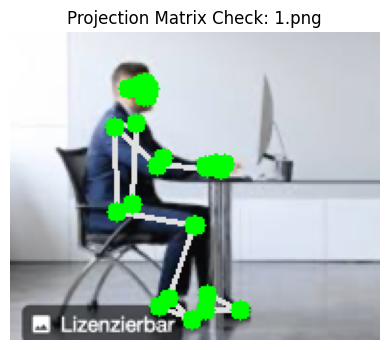

In [12]:
# Define or load a 4x4 projection matrix (this is a simple identity matrix for demonstration).
# Replace with an actual matrix if you have camera calibration data or other transformation requirements.
custom_projection_matrix = np.eye(4, dtype=np.float32)

# Call the function with your directory containing raw images and your projection matrix.
check_landmarks_in_images_with_projection(
    image_dir="raw_images",
    projection_matrix=custom_projection_matrix
)